In [1]:
import pandas as pd
import re
import os
import matplotlib.pyplot as plt
from IPython.display import display
import warnings
warnings.simplefilter('always')

from scripts.a_data_loading_cleaning import run_load_clean_diagnose_data

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Data Loading & Cleaning

In [ ]:
csv_path = f"results/scenarios_results.csv"
df = run_load_clean_diagnose_data(csv_path)

✅ Total generated tokens value is constant: 16384
Original distribution:
total_generated_tokens
16384    24
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
Round 1: Verfifying FLOPs on raw df
✅ FLOPs value is constant: 52638582308864
Original distribution:
flops
52638582308864    24
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
✅ FLOPs are unique per model
----------------------------------------------------------------------------------------------------
cyles present: [1 2]


# Basic understanding on contents

In [3]:


print(f"number of observation: {len(df)}")
print(f"number of scenarios: {len(df['config_name'].unique())}")
print(f"distribution of scenarios:{df['config_name'].value_counts()}")

number of observation: 12
number of scenarios: 12
distribution of scenarios:config_name
A1_Max_Throughput_Exploit                 1
A4_Latency_Ignorance_Exploit              1
R4_High_Load_Cloud_API_Deployment         1
R3_Balanced_Enterprise_Service            1
A5_Parallel_Overdrive                     1
A2_Precision_Minimalist                   1
R7_anti_platonic_ideal                    1
A3_Quantisation_Gaming                    1
R2_Low_Latency_Chatbot_Deployment         1
R1_Standard_Production_Config             1
R5_Real_Time_Mobile_Inference             1
R6_Medium_Scale_Language_Model_Serving    1
Name: count, dtype: int64


In [4]:
cols_to_describe = [
    'total_energy_kwh',
    'total_inference_time_sec',
    'average_latency_ms_per_batch',
    'throughput_queries_per_sec',
    'throughput_tokens_per_sec',
    'cpu_energy_total',
    'gpu_energy_total',
    'flops_per_token',
    'energy_per_token_kwh',
    'divergence_energy_flops'
]

df[cols_to_describe].describe()

,total_energy_kwh,total_inference_time_sec,average_latency_ms_per_batch,throughput_queries_per_sec,throughput_tokens_per_sec,cpu_energy_total,gpu_energy_total,flops_per_token,energy_per_token_kwh,divergence_energy_flops
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,1.200000e+01,1.200000e+01,1.200000e+01
mean,0.045729,207.050207,7237.570020,5.989027,766.595434,0.012268,0.033393,3.212804e+09,2.791080e-06,8.687365e-16
std,0.100536,430.256267,3624.696085,5.377419,688.309616,0.023510,0.079378,0.000000e+00,6.136253e-06,1.909937e-15
min,0.001275,9.320546,3833.126482,0.087479,11.197267,0.000449,0.000770,3.212804e+09,7.780156e-08,2.421609e-17
25%,0.004162,13.198778,4710.808373,1.452209,185.882781,0.001018,0.002375,3.212804e+09,2.540147e-07,7.906325e-17
50%,0.010719,34.158685,5620.975538,4.854941,621.432442,0.002145,0.008810,3.212804e+09,6.542447e-07,2.036367e-16
75%,0.030392,93.778450,9400.772579,9.952348,1273.900509,0.006683,0.016263,3.212804e+09,1.854998e-06,5.773765e-16
max,0.359093,1463.214133,15703.214452,13.733102,1757.837019,0.075955,0.282738,3.212804e+09,2.191731e-05,6.821864e-15


📊 Plotting histogram...


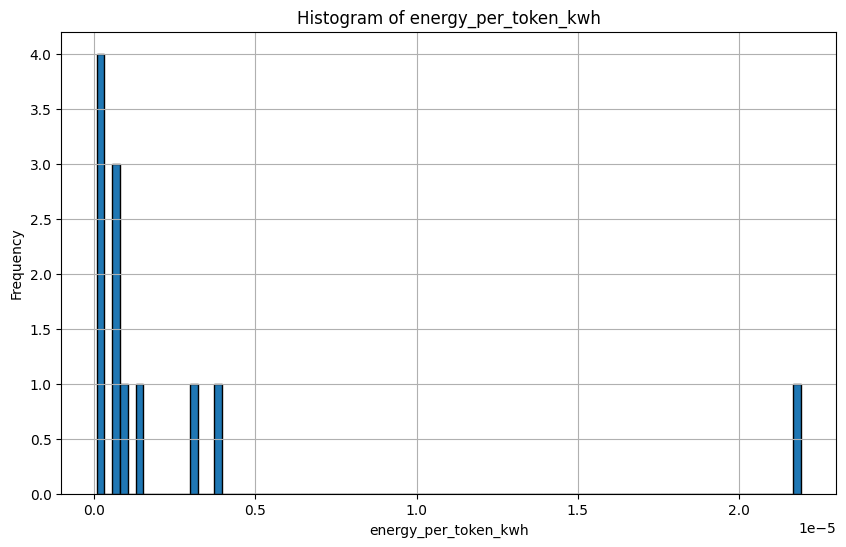

📊 Plotting normalised histogram...


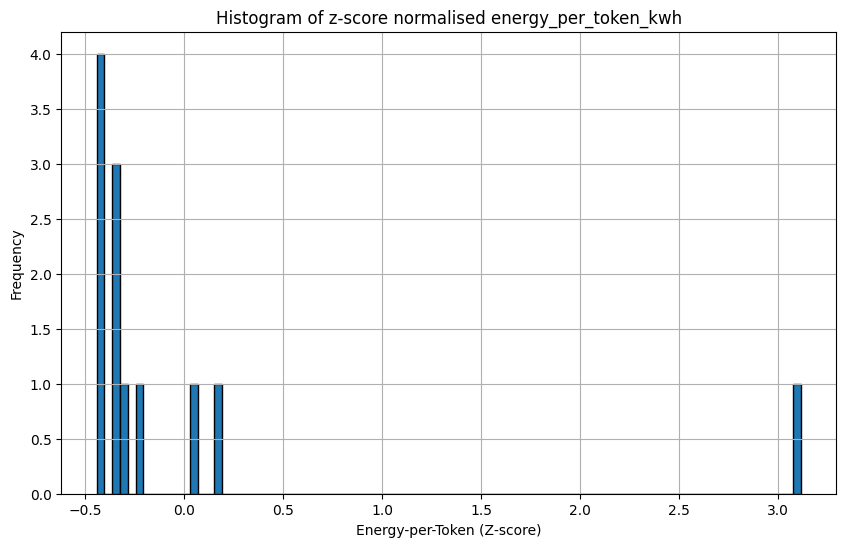

📦 Plotting boxplot...


/Users/henrybaker/repositories/thesis_analysis/scripts/b_exploratory_data_analysis.py:45: PendingDeprecationWarning: vert: bool will be deprecated in a future version. Use orientation: {'vertical', 'horizontal'} instead.
  plt.boxplot(data[column].dropna(), vert=False)


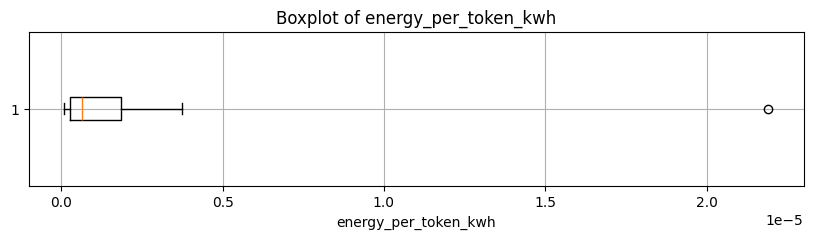

🔬 Scatter: Energy vs FLOPs...


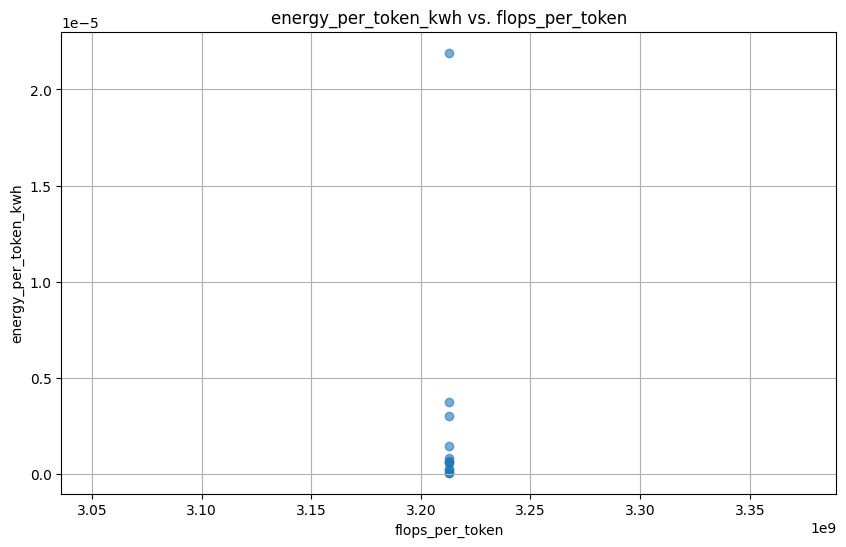

📈 Scatter: Divergence vs Batch Size...


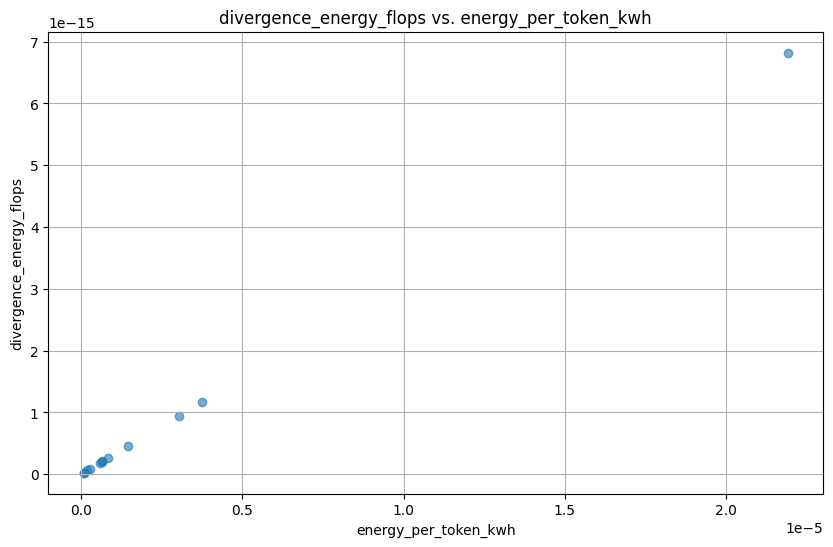

🔗 Correlation matrix...


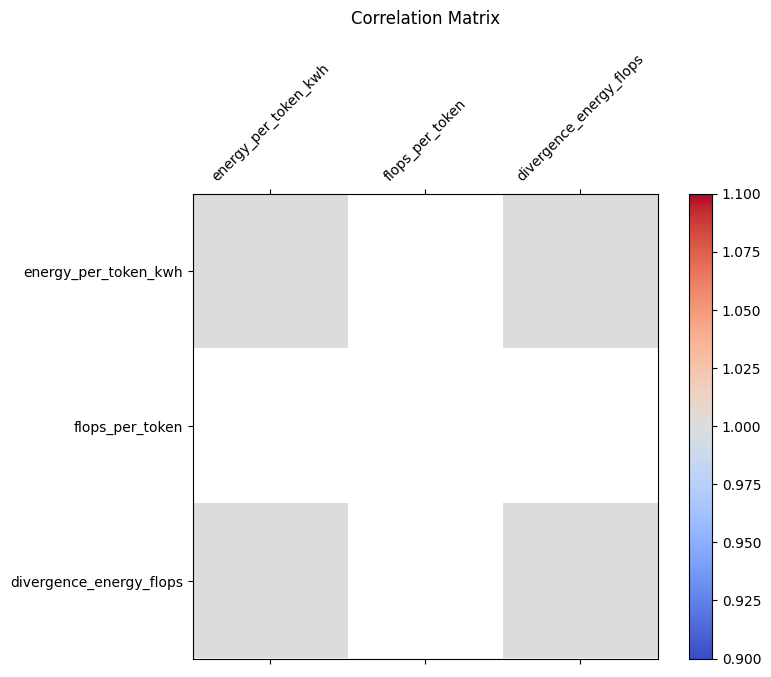

In [5]:
from scripts.b_exploratory_data_analysis import (
    plot_histogram,
    plot_boxplot,
    plot_scatter,
    plot_divergence,
    plot_correlation_matrix,
    plot_all_diagnostics
)

plot_all_diagnostics(df)

To do:
- [X] get the outliers
- [ ] unpack the divergence plot more
- [ ] work on the correlation matrix

In [6]:
# outliers:
outliers = df[(df['energy_per_token_kwh'] - df['energy_per_token_kwh'].mean()).abs() > 3 * df['energy_per_token_kwh'].std()]
print(outliers[['config_name', 'energy_per_token_kwh']])


              config_name  energy_per_token_kwh
6  R7_anti_platonic_ideal              0.000022


# Basic stats

In [7]:
from scripts.f_scenario_analysis import get_descriptive_stats
get_descriptive_stats(df)


Models: ['meta-llama/Llama-3.2-3B']

Model: meta-llama/Llama-3.2-3B

    - Config w/ MAX Mean Energy: R7_anti_platonic_ideal (0.0000 kWh)
    - Config w/ MIN Mean Energy: A3_Quantisation_Gaming (0.0000 kWh)

 ==Standard normalisation (relative to mean):==
    - Energy range is 782.48% of the MEAN of config means.

 ==Normalized to baseline (min mean config):==
    - Energy range is 28070.79% of the MIN of config means.
                               config_name  norm_to_min  diff_to_min_pct
0                A1_Max_Throughput_Exploit     7.420530         6.420530
1                  A2_Precision_Minimalist     2.446599         1.446599
2                   A3_Quantisation_Gaming     1.000000         0.000000
3             A4_Latency_Ignorance_Exploit     1.045092         0.045092
4                    A5_Parallel_Overdrive     8.302604         7.302604
5            R1_Standard_Production_Config    38.886896        37.886896
6        R2_Low_Latency_Chatbot_Deployment     8.515687         7

<Axes: title={'center': 'Distribution of Normalised Energy per Token'}, xlabel='Energy per Token (normalised by mean) \n"How many times bigger (or smaller) is this value than the average?"', ylabel='Frequency'>

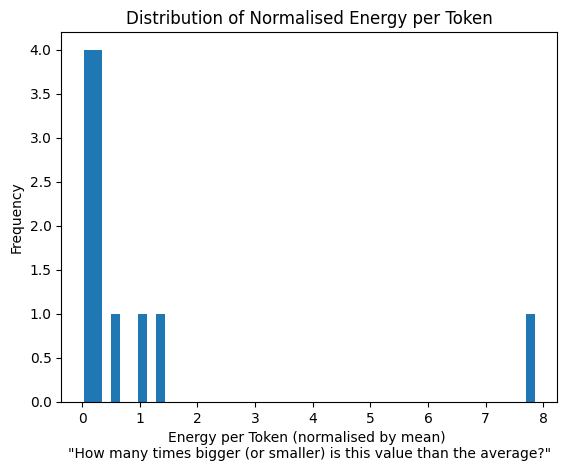

In [8]:
(df['energy_per_token_kwh'] / df['energy_per_token_kwh'].mean()).plot(
    kind='hist',
    bins=50,
    title='Distribution of Normalised Energy per Token',
    xlabel='Energy per Token (normalised by mean) \n"How many times bigger (or smaller) is this value than the average?"',
    ylabel='Frequency'
)

# Absolute Numbers

In [9]:
from scripts.f_scenario_analysis import compare_energy_to_appliances
compare_energy_to_appliances(df)

== ASSUMING AVERAGE LENGTH: 300 TOKENS ==
Models: ['meta-llama/Llama-3.2-3B']

=== Model: meta-llama/Llama-3.2-3B ===
-- Scenario: Full config means (12 configs) --
Overall ratio (max/min): 281.71
# responses to match appliance (worst/best/diff/mean):
    iPhone_charge: worst 1.52, best 428.44, diff 1.53, mean 11.94
    laptop_charge: worst 7.60, best 2142.20, diff 7.63, mean 59.71
    wifi_router_24h: worst 3.65, best 1028.26, diff 3.66, mean 28.66
    streaming_1hr: worst 7.60, best 2142.20, diff 7.63, mean 59.71
    google_search: worst 0.05, best 12.85, diff 0.05, mean 0.36
    kettle: worst 15.21, best 4284.40, diff 15.26, mean 119.43
    shower: worst 395.43, best 111394.51, diff 396.83, mean 3105.13

-- Scenario: Without outlier configs (11 configs) --
Overall ratio (max/min): 48.08
# responses to match appliance (worst/best/diff/mean):
    iPhone_charge: worst 8.91, best 428.44, diff 9.10, mean 31.68
    laptop_charge: worst 44.55, best 2142.20, diff 45.50, mean 158.38
    wifi

NB: this is the TinyLLama model -> do scenarios with largest possible LLaMa model!
Also, do this with non-extreme (all the realistic scenarios vs non-realistic scenarios)

# Modeling

In [10]:
df.columns

Index(['config_name', 'experiment_id', 'date_time', 'model', 'num_processes',
       'batch_size___fixed_batching', 'decoder_temperature', 'decoder_top_k',
       'decoder_top_p', 'latency_simulation_simulate',
       'latency_simulation_delay_max', 'latency_simulation_delay_min',
       'latency_simulation_simulate_burst', 'latency_simulation_burst_size',
       'latency_simulation_burst_interval', 'fp_precision', 'quantization',
       'load_in_8bit', 'load_in_4bit', 'total_input_tokens',
       'total_generated_tokens', 'date_time', 'total_params',
       'max_input_tokens', 'max_output_tokens', 'number_input_prompts',
       'total_energy_kwh', 'total_energy_joules', 'flops', 'tokens_per_joule',
       'joules_per_token', 'flops_per_joule', 'joules_per_flop',
       'total_inference_time_sec', 'average_latency_ms_per_batch',
       'throughput_queries_per_sec', 'throughput_tokens_per_sec',
       'total_energy_kwh_process_0', 'total_energy_kwh_process_1',
       'total_energy_kwh_p


📊 Running OLS regression for energy_per_token_kwh...

                             OLS Regression Results                             
Dep. Variable:     energy_per_token_kwh   R-squared:                       0.816
Model:                              OLS   Adj. R-squared:                  0.325
Method:                   Least Squares   F-statistic:                     1.663
Date:                  Thu, 24 Apr 2025   Prob (F-statistic):              0.368
Time:                          17:18:47   Log-Likelihood:                 137.67
No. Observations:                    12   AIC:                            -257.3
Df Residuals:                         3   BIC:                            -253.0
Df Model:                             8                                         
Covariance Type:              nonrobust                                         
                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)
/Users/henrybaker/miniconda3/envs/thesis/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=12 observations were given.
  return hypotest_fun_in(*args, **kwds)


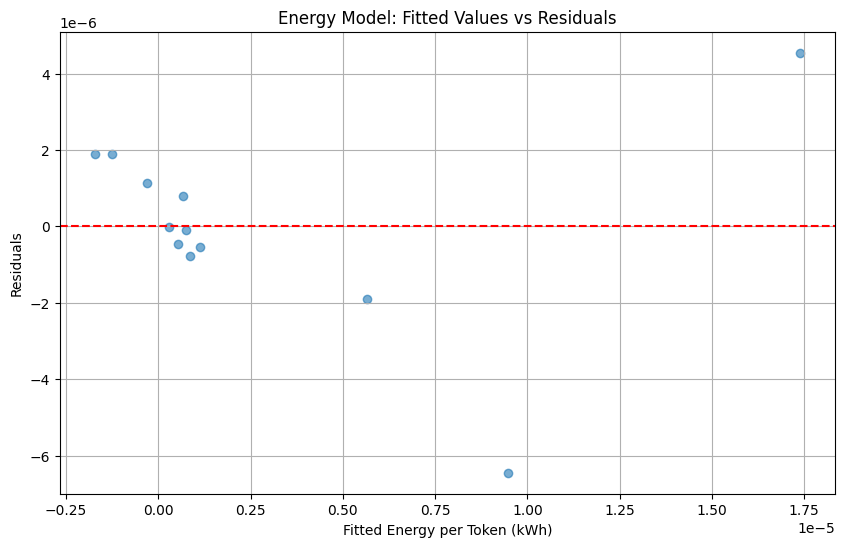

In [11]:
from scripts.d_base_regression import run_full_regression_analysis, preprocess_data

df = preprocess_data(df)

# With custom predictors
custom_predictors = [
                     "num_processes", 
                     "batch_size_numeric", 
                     "C(decoder_config_decoding_mode)", 
                     "C(latency_simulation_simulate)", 
                     "C(fp_precision)", 
                     "C(quantization)", 
                     "total_inference_time_sec"
                     ]
run_full_regression_analysis(df, predictors=custom_predictors)
